In [85]:
# ================================
# IMPORT LIBRARIES AND SETUP
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path
import seaborn as sns
import warnings
import os
import pickle
from pykalman import KalmanFilter
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler ,StandardScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import entropy
from scipy.fft import rfft, rfftfreq
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

# Set random seeds for reproducibility
np.random.seed(42)

# Create directories for artifacts and visualizations
artifacts_dir = Path('artifacts')
artifacts_dir.mkdir(exist_ok=True)
viz_dir = Path('visualization')
viz_dir.mkdir(exist_ok=True)

os.makedirs(artifacts_dir, exist_ok=True)

print("All libraries imported successfully!")
print(f"Artifacts will be saved in: {artifacts_dir}")
print(f"Visualizations will be saved in: {viz_dir}")

All libraries imported successfully!
Artifacts will be saved in: artifacts
Visualizations will be saved in: visualization


In [51]:
# ================================
# DATA ACQUISITION
# ================================

# Load the TON_IoT door sensor dataset
# Note: Replace 'ton_iot_door_sensor.csv' with your actual file path
df = pd.read_csv(r'D:\Skripsi\Train_Test_datasets\Train_Test_IoT_dataset\Train_Test_IoT_Garage_Door.csv')
print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

# Display basic information about the dataset
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(df.head(10))
print(f"\nDataset Info:")
print(df.info())
print(f"\nDataset Description:")
print(df.describe())

Dataset loaded successfully!
Dataset shape: (39587, 6)

DATASET OVERVIEW
        date        time door_state sphone_signal  label  type
0  25-Apr-19   14:42:33      closed             0      1  ddos
1  25-Apr-19   14:42:38      closed             0      1  ddos
2  25-Apr-19   14:42:43      closed             0      1  ddos
3  25-Apr-19   14:42:48      closed             0      1  ddos
4  25-Apr-19   14:42:58      closed             0      1  ddos
5  25-Apr-19   14:43:03      closed             0      1  ddos
6  25-Apr-19   14:43:08      closed             0      1  ddos
7  25-Apr-19   14:43:13        open             1      1  ddos
8  25-Apr-19   14:43:18      closed             0      1  ddos
9  25-Apr-19   14:43:23      closed             0      1  ddos

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39587 entries, 0 to 39586
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           39587

In [52]:
def normalize_phone_signal(value):
    """
    Mengubah berbagai representasi nilai signal menjadi biner (0 atau 1)
    
    Parameter:
    value: nilai input yang akan dinormalisasi
    
    Return:
    int: 0 atau 1
    """
    if isinstance(value, bool):
        return 1 if value else 0
    elif isinstance(value, str):
        value = value.lower().strip()
        if value == "true":
            return 1
        elif value == "false":
            return 0
        else:
            try:
                num = float(value)
                return 1 if num > 0 else 0
            except ValueError:
                return 0
    else:
        try:
            # Handle angka (int/float)
            return 1 if float(value) > 0 else 0
        except (ValueError, TypeError):
            return 0

In [53]:
df['sphone_signal'] = df['sphone_signal'].apply(normalize_phone_signal)

In [54]:
df['sphone_signal'].value_counts()

sphone_signal
0    35575
1     4012
Name: count, dtype: int64


DATA EXPLORATION
Data Types:
date             object
time             object
door_state       object
sphone_signal     int64
label             int64
type             object
dtype: object

Unique door states: ['closed' 'open']
Unique phone signal values: [0 1]
Attack type distribution:
type
normal        15000
ddos           5000
backdoor       5000
injection      5000
password       5000
ransomware     2902
xss            1156
scanning        529
Name: count, dtype: int64


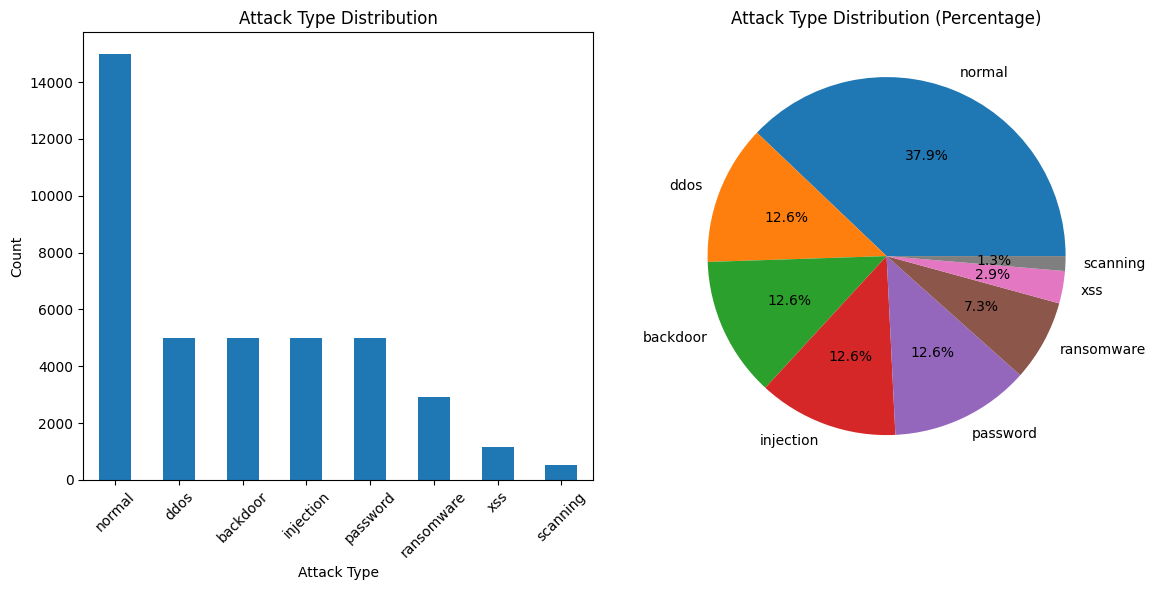

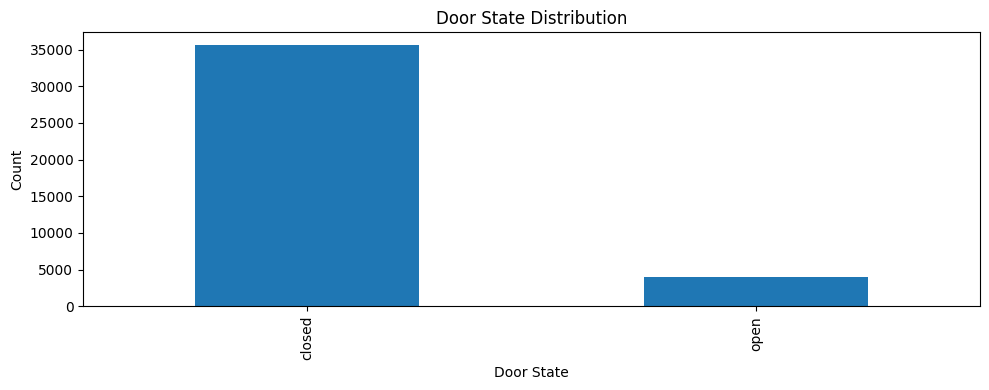

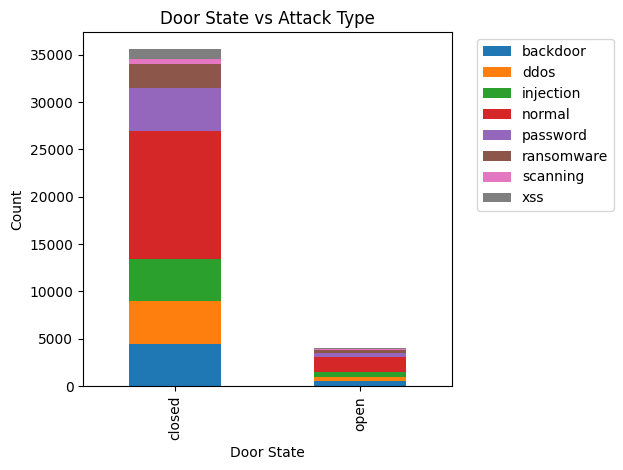

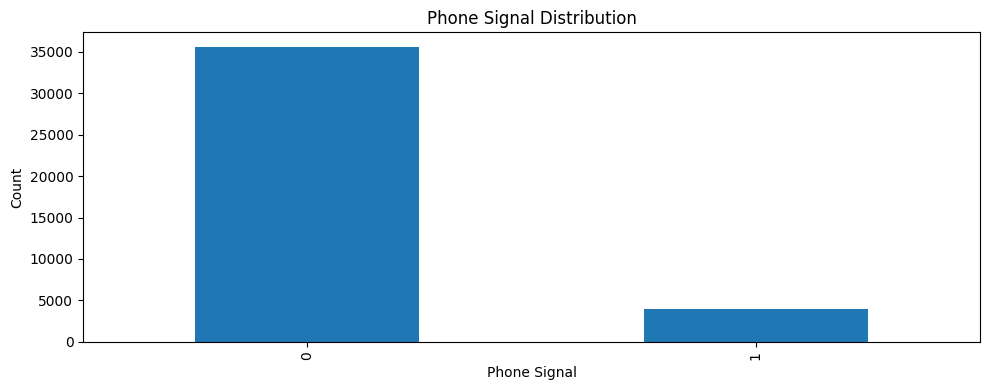

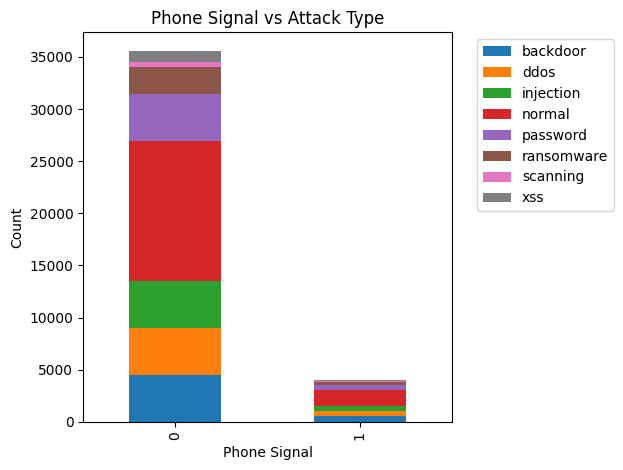

In [55]:
# ================================
# DATA EXPLORATION
# ================================

print("\n" + "="*50)
print("DATA EXPLORATION")
print("="*50)

# Check data types
print("Data Types:")
print(df.dtypes)

# Check unique values in categorical columns
print(f"\nUnique door states: {df['door_state'].unique()}")
print(f"Unique phone signal values: {df['sphone_signal'].unique()}")
print(f"Attack type distribution:")
attack_distribution = df['type'].value_counts()
print(attack_distribution)

# Visualize attack type distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df['type'].value_counts().plot(kind='bar', rot=45)
plt.title('Attack Type Distribution')
plt.xlabel('Attack Type')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Attack Type Distribution (Percentage)')
plt.ylabel('')

plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'attack_type_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

# Door state distribution
plt.figure(figsize=(10, 4))
df['door_state'].value_counts().plot(kind='bar')
plt.title('Door State Distribution')
plt.xlabel('Door State')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'door_state_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

pd.crosstab(df['door_state'], df['type']).plot(kind='bar', stacked=True)
plt.title('Door State vs Attack Type')
plt.xlabel('Door State')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'door_state_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

# Phone signal distribution
plt.figure(figsize=(10, 4))
df['sphone_signal'].value_counts().plot(kind='bar')
plt.title('Phone Signal Distribution')
plt.xlabel('Phone Signal')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'phone_signal_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

pd.crosstab(df['sphone_signal'], df['type']).plot(kind='bar', stacked=True)
plt.title('Phone Signal vs Attack Type')
plt.xlabel('Phone Signal')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'phone_signal_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Implementasi Kalman Filter untuk sphone_signal
def apply_kalman_filter(signal_data):
    if hasattr(signal_data, 'values'):
        signal_array = signal_data.values
    else:
        signal_array = np.array(signal_data)
    observations = signal_array.reshape(-1, 1)
    kf = KalmanFilter(
        transition_matrices=np.array([[1, 1], [0, 1]]),
        observation_matrices=np.array([[1, 0]]),
        initial_state_mean=np.array([signal_array[0], 0]),
        initial_state_covariance=np.eye(2),
        observation_covariance=np.array([[1.0]]),
        transition_covariance=np.array([[0.1, 0], [0, 0.1]]),
        n_dim_state=2
    )
    kf_fitted = kf.em(observations, n_iter=10)
    state_means, _ = kf_fitted.smooth(observations)
    return state_means[:, 0]

In [56]:
df_filtered = df.copy()
# df_filtered['sphone_signal'] = apply_kalman_filter(df['sphone_signal'])

In [57]:
# ================================
# FEATURE ENGINEERING
# ================================

print("\n" + "="*50)
print("FEATURE ENGINEERING")
print("="*50)

df_processed = df_filtered.copy()

# Gabung datetime dan ekstrak komponen
df_processed['datetime'] = pd.to_datetime(df_processed['date'].str.strip() + ' ' + df_processed['time'].str.strip(),
                                format='%d-%b-%y %H:%M:%S', errors='coerce')
df_processed = df_processed.sort_values('datetime')
df_processed['hour']        = df_processed['datetime'].dt.hour
df_processed['minute']      = df_processed['datetime'].dt.minute
df_processed['second']      = df_processed['datetime'].dt.second
df_processed['day_of_week'] = df_processed['datetime'].dt.dayofweek
df_processed['is_weekend']  = (df_processed['day_of_week'] >= 5).astype(int)
df_processed['hour_sin']    = np.sin(2*np.pi*df_processed['hour']/24)
df_processed['hour_cos']    = np.cos(2*np.pi*df_processed['hour']/24)
df_processed['min_sin']     = np.sin(2*np.pi*df_processed['minute']/60)
df_processed['min_cos']     = np.cos(2*np.pi*df_processed['minute']/60)

# Encode door state
le = LabelEncoder()
df_processed['door_state_encoded'] = le.fit_transform(df_processed['door_state'])

# Time diff
df_processed['time_diff'] = df_processed['datetime'].diff().dt.total_seconds().fillna(0)

# Rolling window stats (window=10)
win = 10
roll_groups = df_processed[['door_state_encoded','sphone_signal']].rolling(window=win, min_periods=1)

df_processed['door_roll_mean'] = roll_groups['door_state_encoded'].mean()
df_processed['door_roll_std']      = roll_groups['door_state_encoded'].std().fillna(0)
df_processed['phone_roll_mean']    = roll_groups['sphone_signal'].mean()
df_processed['phone_roll_std']     = roll_groups['sphone_signal'].std().fillna(0)

# Domain‑spesifik (FFT dominant freq & entropy) — seperti sebelumnya
def dominant_freq(arr, sr=1.0):
    yf = np.abs(rfft(arr))
    xf = rfftfreq(len(arr), d=1/sr)
    idx = np.argmax(yf[1:]) + 1
    return xf[idx]

df_processed['door_dom_freq'] = (
    df_processed['door_state_encoded']
      .rolling(window=win, min_periods=win)
      .apply(lambda x: dominant_freq(x.values), raw=False)
      .fillna(0)
)

df_processed['phone_dom_freq'] = (
    df_processed['sphone_signal']
      .rolling(window=win, min_periods=win)
      .apply(lambda x: dominant_freq(x.values), raw=False)
      .fillna(0)
)

def window_entropy(arr):
    p,_ = np.histogram(arr, bins=10, density=True)
    p = p[p>0]
    return entropy(p)

df_processed['door_entropy'] = (
    df_processed['door_state_encoded']
      .rolling(window=win, min_periods=win)
      .apply(lambda x: window_entropy(x.values), raw=False)
      .fillna(0)
)

df_processed['phone_entropy'] = (
    df_processed['sphone_signal']
      .rolling(window=win, min_periods=win)
      .apply(lambda x: window_entropy(x.values), raw=False)
      .fillna(0)
)

print("Feature engineering extended. Columns:", 
      [c for c in df_processed.columns if c not in df_filtered.columns])


FEATURE ENGINEERING
Feature engineering extended. Columns: ['datetime', 'hour', 'minute', 'second', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos', 'door_state_encoded', 'time_diff', 'door_roll_mean', 'door_roll_std', 'phone_roll_mean', 'phone_roll_std', 'door_dom_freq', 'phone_dom_freq', 'door_entropy', 'phone_entropy']


In [58]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39587 entries, 25902 to 5982
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                39587 non-null  object        
 1   time                39587 non-null  object        
 2   door_state          39587 non-null  object        
 3   sphone_signal       39587 non-null  int64         
 4   label               39587 non-null  int64         
 5   type                39587 non-null  object        
 6   datetime            39587 non-null  datetime64[ns]
 7   hour                39587 non-null  int32         
 8   minute              39587 non-null  int32         
 9   second              39587 non-null  int32         
 10  day_of_week         39587 non-null  int32         
 11  is_weekend          39587 non-null  int32         
 12  hour_sin            39587 non-null  float64       
 13  hour_cos            39587 non-null  float64     

In [59]:
# ================================
# IDENTIFYING MISSING VALUES
# ================================

print("\n" + "="*50)
print("MISSING VALUES ANALYSIS")
print("="*50)

# Check for missing values
missing_values = df_processed.isnull().sum()
missing_percentage = (missing_values / len(df_processed)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
})

print("Missing values summary:")
print(missing_df[missing_df['Missing Count'] > 0])

# Visualize missing values if any
if missing_values.sum() > 0:
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_processed.isnull(), cbar=True, yticklabels=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.savefig(os.path.join(viz_dir, 'missing_values_heatmap.png'), dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No missing values found in the dataset!")


MISSING VALUES ANALYSIS
Missing values summary:
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []
No missing values found in the dataset!


In [60]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39587 entries, 25902 to 5982
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                39587 non-null  object        
 1   time                39587 non-null  object        
 2   door_state          39587 non-null  object        
 3   sphone_signal       39587 non-null  int64         
 4   label               39587 non-null  int64         
 5   type                39587 non-null  object        
 6   datetime            39587 non-null  datetime64[ns]
 7   hour                39587 non-null  int32         
 8   minute              39587 non-null  int32         
 9   second              39587 non-null  int32         
 10  day_of_week         39587 non-null  int32         
 11  is_weekend          39587 non-null  int32         
 12  hour_sin            39587 non-null  float64       
 13  hour_cos            39587 non-null  float64     

In [ ]:
# ================================
# SIMPLE IMPUTER AND MINMAX SCALER
# ================================

print("\n" + "="*50)
print("DATA PREPROCESSING - IMPUTATION AND SCALING")
print("="*50)

# Prepare features and target
X = df_processed.copy()
X.drop(['date','time','door_state','datetime','type','label'], axis=1, inplace=True)
y = df_processed['type'].copy()



# Handle any remaining missing values with SimpleImputer
# imputer = SimpleImputer(strategy='median')
# X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# print(f"Features shape after imputation: {X_imputed.shape}")

# Apply MinMax Scaling
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print("Data scaling completed!")
print(f"Scaled features shape: {X_scaled.shape}")

# Save preprocessors
# with open(os.path.join(artifacts_dir, 'imputer.pkl'), 'wb') as f:
#     pickle.dump(imputer, f)

with open(os.path.join(artifacts_dir, 'minmax.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

# print(f"Imputer saved to {artifacts_dir}/imputer.pkl")
print(f"Scaler saved to {artifacts_dir}/minmax.pkl")

# Encode target labels
label_encoder_target = LabelEncoder()
y_encoded = label_encoder_target.fit_transform(y)

# Save target label encoder
with open(os.path.join(artifacts_dir, 'label_encoder_target.pkl'), 'wb') as f:
    pickle.dump(label_encoder_target, f)

print(f"Target classes: {label_encoder_target.classes_}")
print(f"Target shape: {y_encoded.shape}")
print(f"Target label encoder saved to {artifacts_dir}/label_encoder_target.pkl")


DATA PREPROCESSING - IMPUTATION AND SCALING
Data scaling completed!
Scaled features shape: (39587, 20)
Scaler saved to artifacts/minmax.pkl
Target classes: ['backdoor' 'ddos' 'injection' 'normal' 'password' 'ransomware' 'scanning'
 'xss']
Target shape: (39587,)
Target label encoder saved to artifacts/label_encoder_target.pkl


In [62]:
y_cat = to_categorical(y_encoded)

In [63]:
print(X_scaled.info())
print('\n',y_encoded.shape)
print('\n',y_encoded[:10])
print('\n',y_cat.shape)
print('\n',y_cat[:10])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39587 entries, 0 to 39586
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sphone_signal       39587 non-null  float64
 1   hour                39587 non-null  float64
 2   minute              39587 non-null  float64
 3   second              39587 non-null  float64
 4   day_of_week         39587 non-null  float64
 5   is_weekend          39587 non-null  float64
 6   hour_sin            39587 non-null  float64
 7   hour_cos            39587 non-null  float64
 8   min_sin             39587 non-null  float64
 9   min_cos             39587 non-null  float64
 10  door_state_encoded  39587 non-null  float64
 11  time_diff           39587 non-null  float64
 12  door_roll_mean      39587 non-null  float64
 13  door_roll_std       39587 non-null  float64
 14  phone_roll_mean     39587 non-null  float64
 15  phone_roll_std      39587 non-null  float64
 16  door

In [ ]:
# ================================
# SELEKSI FITUR GA
# ================================

# Split data validasi untuk fitness eval
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_cat, test_size=0.2, random_state=42, stratify=y_encoded)

# --- Parameters GA ---
POP_SIZE = 20
N_GENERATIONS = 10
MUTATION_RATE = 0.1
TOURNAMENT_SIZE = 3
FEATURE_COUNT = X.shape[1]

# --- Fungsi buat model LSTM ---
def create_lstm_model(input_shape, n_classes):
    model = Sequential([
        LSTM(32, input_shape=input_shape),
        Dropout(0.2),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# --- Fungsi fitness ---
def fitness(individual):
    if sum(individual) == 0:
        return 0.0,

    selected_features = [i for i, bit in enumerate(individual) if bit == 1]
    X_train_sub = X_train.iloc[:, selected_features].values
    X_val_sub = X_val.iloc[:, selected_features].values

    # reshape to 3D
    X_train_sub = X_train_sub.reshape((X_train_sub.shape[0], 1, X_train_sub.shape[1]))
    X_val_sub = X_val_sub.reshape((X_val_sub.shape[0], 1, X_val_sub.shape[1]))

    model = create_lstm_model(input_shape=(1, len(selected_features)), n_classes=y_cat.shape[1])
    model.fit(X_train_sub, y_train, epochs=3, batch_size=64, verbose=0)

    y_pred = np.argmax(model.predict(X_val_sub, verbose=0), axis=1)
    y_true = np.argmax(y_val, axis=1)
    acc = accuracy_score(y_true, y_pred)

    return acc,

# --- GA tools ---
def init_population():
    return [np.random.randint(0, 2, FEATURE_COUNT).tolist() for _ in range(POP_SIZE)]

def tournament_selection(pop, fitnesses):
    selected = random.sample(list(zip(pop, fitnesses)), TOURNAMENT_SIZE)
    selected = sorted(selected, key=lambda x: x[1][0], reverse=True)  # ambil akurasi dari tuple
    return selected[0][0]

def crossover(parent1, parent2):
    point = random.randint(1, FEATURE_COUNT - 1)
    return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]

def mutate(individual):
    for i in range(FEATURE_COUNT):
        if random.random() < MUTATION_RATE:
            individual[i] = 1 - individual[i]

# --- Main GA Loop ---
population = init_population()
fitnesses = [fitness(ind) for ind in population]

for gen in range(N_GENERATIONS):
    print(f'\nGeneration {gen + 1}/{N_GENERATIONS}')
    
    # Ekstrak nilai fitness dari tuple
    accs = [fit[0] for fit in fitnesses]
    print(f' Best fitness: {max(accs):.4f} | Avg fitness: {np.mean(accs):.4f}')

    new_population = []
    while len(new_population) < POP_SIZE:
        parent1 = tournament_selection(population, fitnesses)
        parent2 = tournament_selection(population, fitnesses)
        child1, child2 = crossover(parent1, parent2)
        mutate(child1)
        mutate(child2)
        new_population.extend([child1, child2])

    # evaluasi populasi baru
    population = new_population[:POP_SIZE]
    fitnesses = [fitness(ind) for ind in population]

# --- Evaluasi akhir ---
accs = [fit[0] for fit in fitnesses]
best_idx = np.argmax(accs)
best_individual = population[best_idx]
selected_features = [i for i, bit in enumerate(best_individual) if bit == 1]

print("\n--- Hasil Seleksi Fitur GA ---")
print("Selected Features Indexes:", selected_features)
print("Best Fitness (Accuracy): {:.4f}".format(accs[best_idx]))


Generation 1/10
 Best fitness: 0.9203 | Avg fitness: 0.7423

Generation 2/10
 Best fitness: 0.9428 | Avg fitness: 0.8832

Generation 3/10
 Best fitness: 0.9459 | Avg fitness: 0.8554

Generation 4/10
 Best fitness: 0.9475 | Avg fitness: 0.8603

Generation 5/10
 Best fitness: 0.9475 | Avg fitness: 0.8885

Generation 6/10
 Best fitness: 0.9475 | Avg fitness: 0.8434

Generation 7/10
 Best fitness: 0.9486 | Avg fitness: 0.8936

Generation 8/10
 Best fitness: 0.9475 | Avg fitness: 0.8749

Generation 9/10
 Best fitness: 0.9475 | Avg fitness: 0.8594

Generation 10/10
 Best fitness: 0.9486 | Avg fitness: 0.8700

--- Hasil Seleksi Fitur GA ---
Selected Features Indexes: [0, 1, 4, 5, 11, 12, 14, 16, 18]
Best Fitness (Accuracy): 0.9475


In [67]:
selected_feature_names = [X_scaled.columns[i] for i in selected_features]
print("Selected Feature Names:", selected_feature_names)

Selected Feature Names: ['sphone_signal', 'hour', 'day_of_week', 'is_weekend', 'time_diff', 'door_roll_mean', 'phone_roll_mean', 'door_dom_freq', 'door_entropy']


In [80]:
X_selected = X_scaled.iloc[:, selected_features]
print(X_selected.shape)
print(X_selected.info())
print(X_selected.head())

(39587, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39587 entries, 0 to 39586
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sphone_signal    39587 non-null  float64
 1   hour             39587 non-null  float64
 2   day_of_week      39587 non-null  float64
 3   is_weekend       39587 non-null  float64
 4   time_diff        39587 non-null  float64
 5   door_roll_mean   39587 non-null  float64
 6   phone_roll_mean  39587 non-null  float64
 7   door_dom_freq    39587 non-null  float64
 8   door_entropy     39587 non-null  float64
dtypes: float64(9)
memory usage: 2.7 MB
None
   sphone_signal  hour  day_of_week  is_weekend  time_diff  door_roll_mean  \
0            0.0  0.45          1.0         1.0        0.0             0.0   
1            0.0  0.45          1.0         1.0        0.0             0.0   
2            0.0  0.45          1.0         1.0        0.0             0.0   
3            0.0  


CORRELATION ANALYSIS


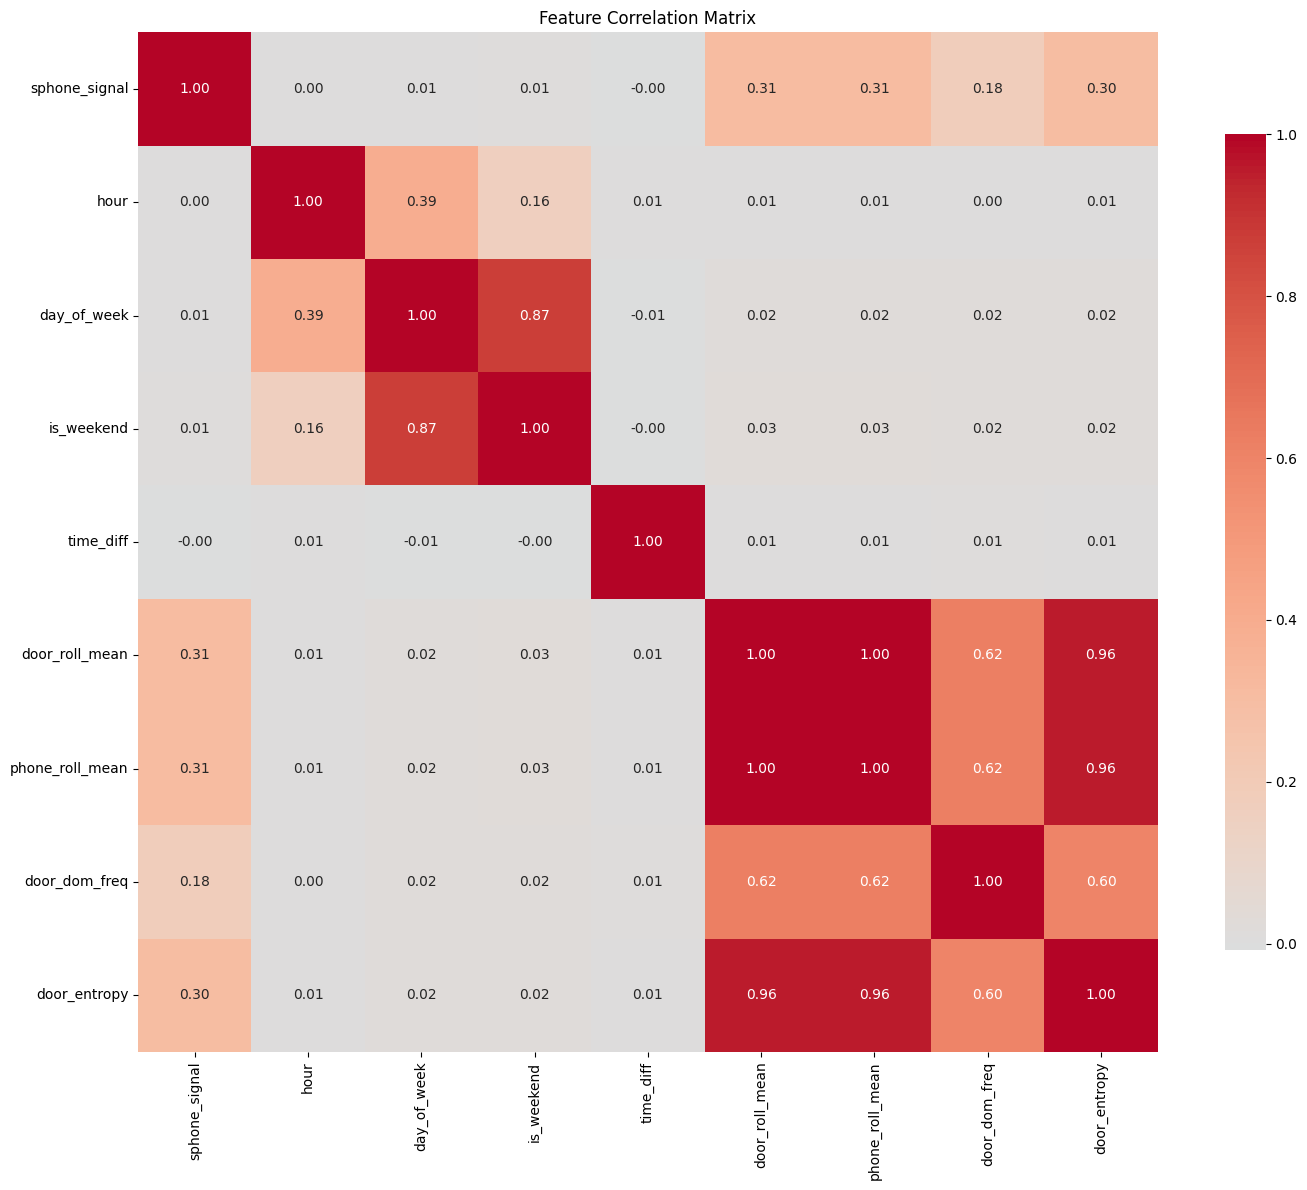

In [81]:
# ================================
# CORRELATION ANALYSIS
# ================================

print("\n" + "="*50)
print("CORRELATION ANALYSIS")
print("="*50)

# Calculate correlation matrix
correlation_matrix = X_selected.corr()

# Visualize correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig(os.path.join(viz_dir, 'correlation_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()

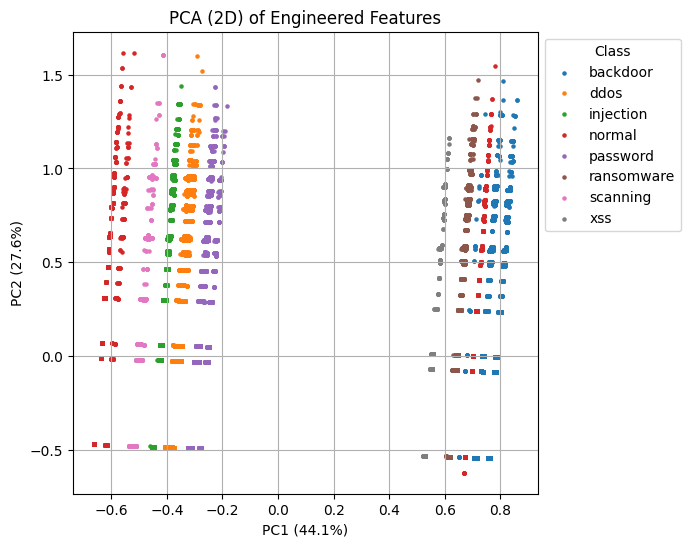

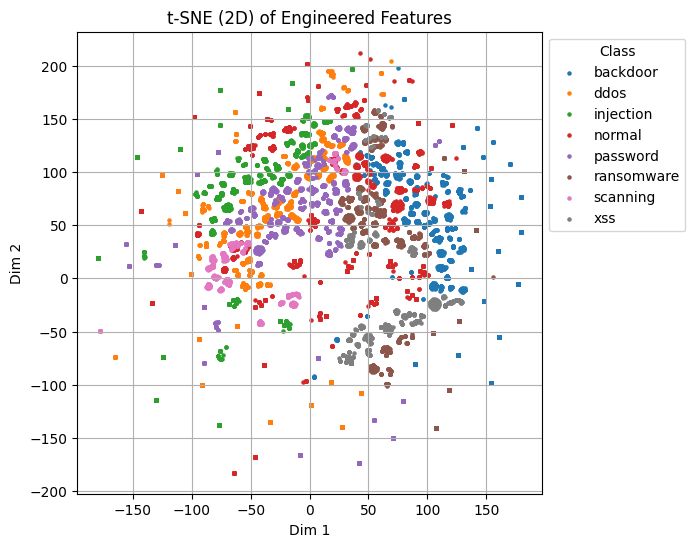

In [82]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_selected)

plt.figure(figsize=(6,6))
for cls in np.unique(y):
    idx = y == cls
    plt.scatter(X_pca[idx,0], X_pca[idx,1], s=5, label=str(cls))
plt.legend(title='Class', bbox_to_anchor=(1,1))
plt.title('PCA (2D) of Engineered Features')
plt.xlabel('PC1 (%.1f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC2 (%.1f%%)' % (pca.explained_variance_ratio_[1]*100))
plt.grid(True)
plt.savefig(os.path.join(viz_dir, 'PCA_engineering_feature.png'), dpi=300, bbox_inches='tight')
plt.show()

# 4) t-SNE → 2 dimensi (lebih lambat)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_selected)  # pada seluruh dataset atau subset

plt.figure(figsize=(6,6))
for cls in np.unique(y):
    idx = y == cls
    plt.scatter(X_tsne[idx,0], X_tsne[idx,1], s=5, label=str(cls))
plt.legend(title='Class', bbox_to_anchor=(1,1))
plt.title('t-SNE (2D) of Engineered Features')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.grid(True)
plt.savefig(os.path.join(viz_dir, 'tSNE_2D_engineering_feature.png'), dpi=300, bbox_inches='tight')
plt.show()

In [83]:
tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=1000, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X_selected)

# 2) Buat DataFrame untuk Plotly
df_tsne = pd.DataFrame({
    'Dim1': X_tsne_3d[:, 0],
    'Dim2': X_tsne_3d[:, 1],
    'Dim3': X_tsne_3d[:, 2],
    'Class': y.astype(str)
})

# 3) Plot interaktif 3D
fig = px.scatter_3d(
    df_tsne,
    x='Dim1', y='Dim2', z='Dim3',
    color='Class',
    opacity=0.7,
    title='t-SNE (3D) of Engineered Features',
    width=900, height=700
)
fig.update_traces(marker=dict(size=4))
fig.update_layout(
    scene = dict(
        xaxis_title='Dim 1',
        yaxis_title='Dim 2',
        zaxis_title='Dim 3'
    ),
    legend_title='Class'
)

# 4) Simpan file HTML ke folder viz_dir
html_path = os.path.join(viz_dir, 'tsne_3d.html')
fig.write_html(html_path)

print(f"File HTML disimpan di: {html_path}")

# PCA ke dalam 3 dimensi
pca = PCA(n_components=3, random_state=42)
X_pca_3d = pca.fit_transform(X_selected)

# Buat DataFrame dari hasil PCA dan label
df_pca = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_pca['label'] = y

# Visualisasi interaktif 3D menggunakan Plotly
fig = px.scatter_3d(
    df_pca, x='PC1', y='PC2', z='PC3',
    color='label',
    title='PCA (3D) of Engineered Features',
    labels={'label': 'Class'},
    opacity=0.7,
    width=800,
    height=600
)

# Simpan hasil visualisasi ke file HTML
output_html_path = os.path.join(viz_dir, 'PCA_3D.html')
fig.write_html(output_html_path)

File HTML disimpan di: visualization\tsne_3d.html


In [86]:
with open(os.path.join(artifacts_dir, 'data_preprocessing.pkl'), 'wb') as f:
    pickle.dump((X_selected, y_encoded), f)
    
# Simpan ke file CSV
# Pastikan X_scaled adalah array 2D dan y_encoded 1D (atau sesuai bentuk)
df_final = pd.DataFrame(X_selected)
df_final['label'] = np.array(y_encoded)

csv_path = os.path.join(artifacts_dir, 'data_preprocessing.csv')
df_final.to_csv(csv_path, index=False)